# ДЗ 01. Введение в нейронные сети

<ol>
    <li>Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?</li>
</ol>

In [1]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/artem/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

def relu(x):
    return x  *  (x  >  0)

def relu_deriv(x):
    return relu(x)*(1-relu(x))

# нормализация массива
def normalize(X, axis=-1, order=2): # на вход
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [3]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
iris_data.head() # расскоментируйте, чтобы посмотреть структуру данных

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# репрезентация данных в виде графиков
#g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

In [5]:
# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


In [6]:
# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

In [7]:
# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y['Species'].value_counts() # какие значения в таргете у нас присутствуют
y = y.values
#print(y.shape)
y = y.flatten()
#print(y.shape)
y = to_one_hot(y)

In [8]:
# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

### Изучим влияние кол-ва эпох обучения

In [ ]:
# присваевание случайных весов
np.random.seed(1)
w0 = 2*np.random.random((4, 5)) - 1 # для входного слоя   - 4 входа, 3 выхода
w1 = 2*np.random.random((5, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода

# скорость обучения (learning rate)
alpha = 0.1#[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

# кол-во итераций в процессе обучения
attempts_qty = [10, 100, 500, 2000, 10000, 20000, 50000, 100000]

# функция, которую будем использовать для активации
activation_functions = ['sigmoid', 'relu']
activation_function = 'relu'

# массивы, чтобы потом построить график
errors = []
accuracies = []
results = []

# процесс обучения
for attempts in attempts_qty:
    for i in range(attempts):

        # прямое распространение(feed forward)
        layer0 = X_train

        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2

        layer2_delta = layer2_error * sigmoid_deriv(layer2)
        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)

        w1 += layer1.T.dot(layer2_delta) * alpha
        w0 += layer0.T.dot(layer1_delta) * alpha

        error = np.mean(np.abs(layer2_error))
        errors.append(error)
        accuracy = (1 - error) * 100
        accuracies.append(accuracy)
        
    item = {'attempts_qty':attempts, 'learning_rate':alpha, 'accuracy':accuracy, 'error':error}
    print(item)
    results.append(item)

### Построим график взаимосвязи кол-ва эпох обучения и ошибки

In [22]:
attempts_influence = [x['attempts_qty'] for x in results]
errors = [x['error'] for x in results]

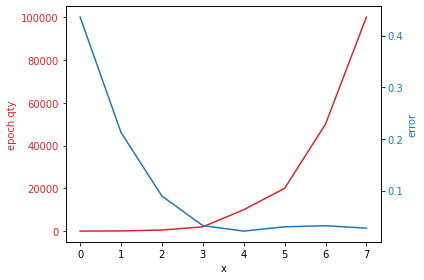

In [23]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('x')
ax1.set_ylabel('epoch qty', color=color)
ax1.plot(attempts_influence, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('error', color=color)  # we already handled the x-label with ax1
ax2.plot(errors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Изучим влияние скорости обучения

In [28]:
# присваевание случайных весов
np.random.seed(1)
w0 = 2*np.random.random((4, 5)) - 1 # для входного слоя   - 4 входа, 3 выхода
w1 = 2*np.random.random((5, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода

# скорость обучения (learning rate)
alphas = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

# кол-во итераций в процессе обучения
attempts_qty = 10000 # [10, 100, 500, 2000, 10000, 20000, 50000, 100000]

# функция, которую будем использовать для активации
activation_functions = ['sigmoid', 'relu']
activation_function = 'relu'

# массивы, чтобы потом построить график
errors = []
accuracies = []
results = []

# процесс обучения
for alpha in alphas:
    for i in range(attempts_qty):

        # прямое распространение(feed forward)
        layer0 = X_train

        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2

        layer2_delta = layer2_error * sigmoid_deriv(layer2)
        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)

        w1 += layer1.T.dot(layer2_delta) * alpha
        w0 += layer0.T.dot(layer1_delta) * alpha

        error = np.mean(np.abs(layer2_error))
        errors.append(error)
        accuracy = (1 - error) * 100
        accuracies.append(accuracy)
        
    item = {'attempts_qty':attempts, 'learning_rate':alpha, 'accuracy':accuracy, 'error':error}
    print(item)
    results.append(item)

{'attempts_qty': 100000, 'learning_rate': 0.1, 'accuracy': 97.82161392786173, 'error': 0.021783860721382716}
{'attempts_qty': 100000, 'learning_rate': 0.05, 'accuracy': 97.86315145038714, 'error': 0.02136848549612857}
{'attempts_qty': 100000, 'learning_rate': 0.01, 'accuracy': 97.86091649049969, 'error': 0.021390835095003103}
{'attempts_qty': 100000, 'learning_rate': 0.005, 'accuracy': 97.85917600706836, 'error': 0.021408239929316397}
{'attempts_qty': 100000, 'learning_rate': 0.001, 'accuracy': 97.85878579635909, 'error': 0.02141214203640906}
{'attempts_qty': 100000, 'learning_rate': 0.0005, 'accuracy': 97.85858584702561, 'error': 0.021414141529743885}
{'attempts_qty': 100000, 'learning_rate': 0.0001, 'accuracy': 97.85854545940083, 'error': 0.02141454540599179}


### Построим график взаимосвязи коэф-та обучения и ошибки

In [31]:
alpha_influence = [x['learning_rate'] for x in results]
errors = [x['error'] for x in results]

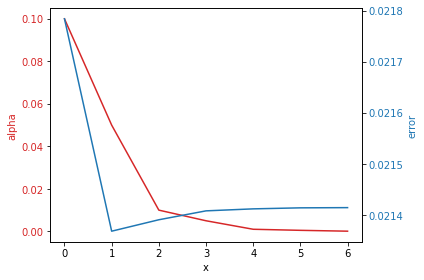

In [32]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('x')
ax1.set_ylabel('alpha', color=color)
ax1.plot(alpha_influence, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('error', color=color)  # we already handled the x-label with ax1
ax2.plot(errors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Выводы:

- параметр "скорость обучения" и "кол-во эпох обучения" находятся во взаимосвязи: чем ниже скорость обучения, тем большее кол-во эпох обучения требуется, тем точнее результат
- к ухудшению точности нейросети приводит увеличение параметра "скорость обучения" и снижение кол-ва эпох обучения
- к улучшению точности нейросети приводит увеличение параметра "кол-во эпох обучения", а также снижение скорости обучения
- Можно сказать, что для каждой задачи существует свой оптимум параметров. Всегда существует риск "перескочить" этот оптимум решения при неправильном (или просто неудачном) подборе параметров